# Laboratorio Dataframes
## Contexto do laboratorio

Trabállase cun dataset real de **voos comerciais**, empregando Apache Spark e a API estruturada de DataFrames.

O obxectivo é:

1. inxerir datos en bruto
2. limpalos e transformalos
3. xerar métricas agregadas
4. visualizar resultados

### Dataset
CSV de voos entre países. 
Tres columnas:
- `ORIGIN_COUNTRY_NAME`
- `DEST_COUNTRY_NAME`
- `count`

### Persistencia
Os datos iranse almacenando nun delta-lake situado en `hdfs:///delta/flights` (é importante crear a estrutura de directorios previamente en HDFS)


In [1]:
# Creación da SparkSession
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("03-Dataframes") \
    .config("spark.sql.legacy.timeParserPolicy", "LEGACY") \
    .getOrCreate()


#spark = SparkSession.builder.getOrCreate()

sc = spark.sparkContext

print("Versión de spark: ",spark.version) # Verifica a versión de Spark

:: loading settings :: url = jar:file:/opt/spark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/hadoop/.ivy2/cache
The jars for the packages stored in: /home/hadoop/.ivy2/jars
io.delta#delta-spark_2.12 added as a dependency
org.apache.spark#spark-sql-kafka-0-10_2.12 added as a dependency
org.apache.kafka#kafka-clients added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-7e705e99-a163-4538-970f-f176cba56f79;1.0
	confs: [default]
	found io.delta#delta-spark_2.12;3.1.0 in central
	found io.delta#delta-storage;3.1.0 in central
	found org.antlr#antlr4-runtime;4.9.3 in central
	found org.apache.spark#spark-sql-kafka-0-10_2.12;3.5.7 in central
	found org.apache.spark#spark-token-provider-kafka-0-10_2.12;3.5.7 in central
	found org.apache.hadoop#hadoop-client-runtime;3.3.4 in central
	found org.apache.hadoop#hadoop-client-api;3.3.4 in central
	found org.xerial.snappy#snappy-java;1.1.10.5 in central
	found org.slf4j#slf4j-api;2.0.7 in central
	found commons-logging#commons-logging;1.1.3 in central
	found com.google.code.fi

Versión de spark:  3.5.7


In [2]:
# Rutas do delta-lake
base = "hdfs:///datalake/flight-lab"   # ou s3a://datalake/flight-lab

bronze_path = f"{base}/bronze/flights"
silver_path = f"{base}/silver/flights"
gold_year_path = f"{base}/gold/flights_by_year"
gold_total_path = f"{base}/gold/flights_total"

Creamos a estrutura de directorios:

In [3]:
%%bash
set -euo pipefail

BASE="hdfs:///datalake/flight-lab"

BRONZE="${BASE}/bronze/flights"
SILVER="${BASE}/silver/flights"
GOLD_YEAR="${BASE}/gold/flights_by_year"
GOLD_TOTAL="${BASE}/gold/flights_total"

echo "==> borrando estrutura anterior (se existe): ${BASE}"
hdfs dfs -test -d "${BASE}" && hdfs dfs -rm -r -f -skipTrash "${BASE}" || true

echo "==> creando directorios"
hdfs dfs -mkdir -p "${BRONZE}" "${SILVER}" "${GOLD_YEAR}" "${GOLD_TOTAL}"

echo "==> estrutura creada:"
hdfs dfs -ls -R "${BASE}"


==> borrando estrutura anterior (se existe): hdfs:///datalake/flight-lab
Deleted hdfs:///datalake/flight-lab
==> creando directorios
==> estrutura creada:
drwxr-xr-x   - hadoop supergroup          0 2026-01-21 10:52 hdfs:///datalake/flight-lab/bronze
drwxr-xr-x   - hadoop supergroup          0 2026-01-21 10:52 hdfs:///datalake/flight-lab/bronze/flights
drwxr-xr-x   - hadoop supergroup          0 2026-01-21 10:52 hdfs:///datalake/flight-lab/gold
drwxr-xr-x   - hadoop supergroup          0 2026-01-21 10:52 hdfs:///datalake/flight-lab/gold/flights_by_year
drwxr-xr-x   - hadoop supergroup          0 2026-01-21 10:52 hdfs:///datalake/flight-lab/gold/flights_total
drwxr-xr-x   - hadoop supergroup          0 2026-01-21 10:52 hdfs:///datalake/flight-lab/silver
drwxr-xr-x   - hadoop supergroup          0 2026-01-21 10:52 hdfs:///datalake/flight-lab/silver/flights


## 🥉 Bronze · Inxestión de datos en bruto

Na capa **bronze** léense os datos tal e como están almacenados, sen aplicar transformacións lóxicas.

Neste caso:
- os datos están en HDFS
- hai varios ficheiros CSV (un por ano)
- o ano non aparece como columna, polo que se extraerá do nome do ficheiro


In [4]:
from pyspark.sql.functions import input_file_name, regexp_extract, col

df_bronze = (
    spark.read
    .option("header", True)
    .option("inferSchema", True)
    .csv("hdfs:///data/flight-data/csv/*-summary.csv")
    .withColumn("source_file", input_file_name())
    .withColumn("year", regexp_extract(col("source_file"), r"/(\d{4})-summary\.csv$", 1).cast("int"))
    .drop(col("source_file"))
)


Comprobación inicial do esquema e dunha pequena mostra de datos (5 filas).


In [5]:
# TODO
df_bronze.printSchema()
df_bronze.show(5)

root
 |-- DEST_COUNTRY_NAME: string (nullable = true)
 |-- ORIGIN_COUNTRY_NAME: string (nullable = true)
 |-- count: integer (nullable = true)
 |-- year: integer (nullable = true)

+-----------------+-------------------+-----+----+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|year|
+-----------------+-------------------+-----+----+
|    United States|            Romania|    1|2010|
|    United States|            Ireland|  264|2010|
|    United States|              India|   69|2010|
|            Egypt|      United States|   24|2010|
|Equatorial Guinea|      United States|    1|2010|
+-----------------+-------------------+-----+----+
only showing top 5 rows



Comprobación de que o ano foi extraído correctamente a partir do nome do ficheiro: amosamos os anos distintos de *df_bronze*.


In [6]:
# TODO
df_bronze.select("year").distinct().show()

[Stage 3:=======================================>                   (4 + 1) / 6]

+----+
|year|
+----+
|2010|
|2015|
|2011|
|2013|
|2012|
|2014|
+----+



Persistimos o *df_bfonze* na ruta *bronze_path* en formato *delta* con modo *overwrite* e particionando por *year*.

In [7]:
# TODO
df_bronze.write.format("delta").mode("overwrite").partitionBy("year").save(bronze_path)

## 🥈 Silver · Limpeza e normalización

Na capa **silver** prepáranse os datos para análise:
- normalízanse nomes de columnas (substituímos `ORIGIN_COUNTRY_NAME` por `origin_country` e `DEST_COUNTRY_NAME` por `dest_country`.
- elimínanse rexistros inválidos, quedámonos só cos que non teñan ningún campo nulo.
- asegúrase a calidade básica dos datos: só rexistros con `count > 0`.

Neste punto mantense a columna `year`, xa que forma parte da semántica do dato.


In [9]:
# TODO
from pyspark.sql.functions import col
df_silver = (
    df_bronze
    .withColumnRenamed("ORIGIN_COUNTRY_NAME","origin_country")
    .withColumnRenamed("DEST_COUNTRY_NAME", "dest_country")
    .filter(col("year").isNotNull())
    .filter(col("origin_country").isNotNull())
    .filter(col("dest_country").isNotNull())
    .filter(col("count") >0)
)

A partir deste momento, cada fila representa un volume de voos identificado por:
- ano
- país de orixe
- país de destino


In [10]:
# TODO: Amosar esquema e 5 elementos
df_silver.printSchema()
df_silver.show(5)


root
 |-- dest_country: string (nullable = true)
 |-- origin_country: string (nullable = true)
 |-- count: integer (nullable = true)
 |-- year: integer (nullable = true)

+-----------------+--------------+-----+----+
|     dest_country|origin_country|count|year|
+-----------------+--------------+-----+----+
|    United States|       Romania|    1|2010|
|    United States|       Ireland|  264|2010|
|    United States|         India|   69|2010|
|            Egypt| United States|   24|2010|
|Equatorial Guinea| United States|    1|2010|
+-----------------+--------------+-----+----+
only showing top 5 rows



## 🧠 Uso de SQL sobre DataFrames

Créase unha vista temporal para facilitar consultas exploratorias mediante SQL.

Lémbrase que as vistas temporais:
- non se persisten
- están ligadas á SparkSession
- seguen sendo avaliadas de forma *lazy*

Neste caso imos facer o seguinte:
- crear unha vista temporal `vuelos` a partir de `df_silver`.
- Amosar os 10 primeiros rexistros empregando SQL.


In [11]:
# TODO
df_silver.createOrReplaceTempView("vuelos")

spark.sql("select * from vuelos limit 10").show()


+-----------------+----------------+-----+----+
|     dest_country|  origin_country|count|year|
+-----------------+----------------+-----+----+
|    United States|         Romania|    1|2010|
|    United States|         Ireland|  264|2010|
|    United States|           India|   69|2010|
|            Egypt|   United States|   24|2010|
|Equatorial Guinea|   United States|    1|2010|
|    United States|       Singapore|   25|2010|
|    United States|         Grenada|   54|2010|
|       Costa Rica|   United States|  477|2010|
|          Senegal|   United States|   29|2010|
|    United States|Marshall Islands|   44|2010|
+-----------------+----------------+-----+----+



Persistimos o dataframe **silver**:
- Almacenamos os datos en *silver_path*.
- Formato delta.
- Modo *overwrite*
- Particionamos por *year*.

In [12]:
# TODO
df_silver.write.format("delta").mode("overwrite").partitionBy("year").save(silver_path)

## 🥇 Gold · Agregacións analíticas

Na capa **gold** constrúense vistas agregadas listas para análise.

Dado que hai varios ficheiros (un por ano), poden existir múltiples rexistros para a mesma relación orixe–destino.

Nesta fase xéranse dúas vistas típicas:
1. agregación anual
2. agregación global (todos os anos)

### Gold anual
Cada fila representa o total de voos entre dous países nun ano concreto.
- Agrupamos por `year`, `origin_country` e `dest_country` e sumamos a columna `count`co alias `total_flights`.
- Amosamos 10 rexistros.


In [13]:
from pyspark.sql.functions import sum as _sum
# TODO
df_gold_year = (
    df_silver
    .groupBy("year","origin_country","dest_country")
    .agg(_sum("count").alias("total_flights"))
)

df_gold_year.show(10)


[Stage 24:================================================>         (5 + 1) / 6]

+----+----------------+-------------+-------------+
|year|  origin_country| dest_country|total_flights|
+----+----------------+-------------+-------------+
|2010|     South Korea|United States|          621|
|2010|       Argentina|United States|          159|
|2010|         Algeria|United States|            1|
|2010|         Vietnam|United States|            1|
|2010|Papua New Guinea|United States|            1|
|2010|     Switzerland|United States|          334|
|2010|   United States|     Dominica|           28|
|2010|   United States|      Nigeria|           16|
|2010|         Ecuador|United States|          345|
|2010|   United States|       Israel|          117|
+----+----------------+-------------+-------------+
only showing top 10 rows



Persistimos o dataframe **gold_year**:
- Almacenamos os datos en *gold_year_path*.
- Formato delta.
- Modo *overwrite*
- Particionamos por *year*.

In [14]:
# TODO
df_gold_year.write.format("delta").mode("overwrite").partitionBy("year").save(gold_year_path)

### Gold global
Nesta vista elimínase a dimensión temporal e calcúlase o volume total acumulado de voos, é dicir:
- Agrupamos por `origin_country` e `dest_country` e sumamos a columna `count`co alias `total_flights`.
- Amosamos 10 rexistros.



In [15]:
# TODO
df_gold_total = (
    df_silver
    .groupBy("origin_country","dest_country")
    .agg(_sum("count").alias("total_flights"))
    .orderBy(col("total_flights").desc())
)

df_gold_total.show(10)



+--------------+--------------+-------------+
|origin_country|  dest_country|total_flights|
+--------------+--------------+-------------+
| United States| United States|      2119795|
|        Canada| United States|        49695|
| United States|        Canada|        49052|
|        Mexico| United States|        38225|
| United States|        Mexico|        38075|
| United States|United Kingdom|        10946|
|United Kingdom| United States|        10358|
| United States|         Japan|         9205|
|         Japan| United States|         8643|
| United States|       Germany|         8501|
+--------------+--------------+-------------+
only showing top 10 rows



Persistimos o dataframe **gold_total**:
- Almacenamos os datos en *gold_total_path*.
- Formato delta.
- Modo *overwrite*
- Particionamos por *year*.

In [16]:
# TODO
df_gold_total.write.format("delta").mode("overwrite").save(gold_total_path)

## 📊 Exportación a Pandas e visualización

Para realizar gráficos empregarase Pandas e librarías de visualización.

⚠️ O método `toPandas()` trae os datos ao proceso do driver, polo que só debe empregarse con subconxuntos pequenos. Collemos só 10 rexistros


In [17]:
df_plot = df_gold_total.limit(20)
pdf = df_plot.toPandas()



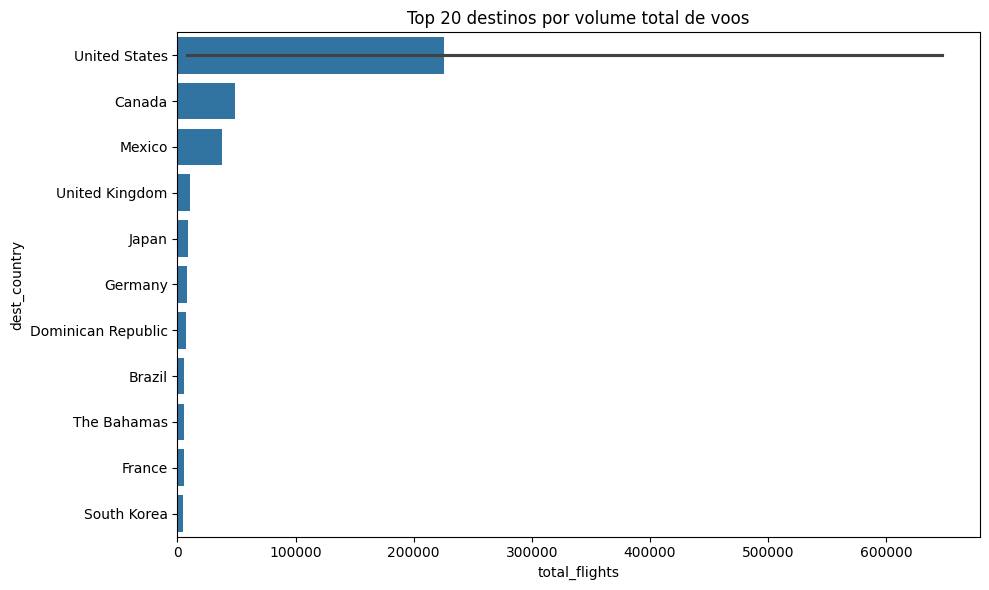

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(
    data=pdf,
    x="total_flights",
    y="dest_country"
)
plt.title("Top 20 destinos por volume total de voos")
plt.tight_layout()
plt.show()


## 🔎 Peche e reflexión

Cuestións para reflexionar:
- En que puntos do laboratorio se executaron accións?
- Que diferenza hai entre bronze, silver e gold neste fluxo?
- Por que non sería correcto empregar `dropDuplicates` neste caso?
- Que cambios serían necesarios se o dataset incluíse xa a columna `year`?
